# Load Data

## hdbscan

In [13]:
import pickle

import pickle
file_path = "../18_rapids/result/20251030_190647/condensed_tree_object.pkl"
with open(file_path, 'rb') as f:
    clusterer = pickle.load(f)





In [14]:

Z, node_id_map = get_linkage_matrix_from_hdbscan(clusterer)

print(Z.shape)
print(Z[1])



len of sorted condensed tree: 344
len of linkage matrix: 172
344
Number of leaves: 173
Leaf ID Map Size: 173
current id: 173
Total Node ID Map Size: 345
current_id: 345
Max Lambda: 2.855132579803467
(172, 5)
[ 70.          71.         174.           0.17586493  70.        ]


## dummy data

In [5]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# ダミーデータの準備 (5点)
X = np.array([
    [1.0, 1.0], [1.5, 1.5], [4.0, 4.0], [4.5, 4.5], [0.0, 5.0]
])
n_points = len(X)

# 連結行列 Z の生成 (ここではScipyを使用。このZを入力として使います)
# Z: [c1, c2, distance, count]
Z = linkage(X, method='single', metric='euclidean')

# Zの内容 (参考)
# print("連結行列 Z:\n", Z)
print(Z)

[[0.         1.         0.70710678 2.        ]
 [2.         3.         0.70710678 2.        ]
 [5.         6.         3.53553391 4.        ]
 [4.         7.         3.80788655 5.        ]]


# Dendrogram

## module

In [8]:

import sys

sys.setrecursionlimit(5000)
print(f"新しい制限: {sys.getrecursionlimit()}")

新しい制限: 5000


In [9]:
import numpy as np
import hdbscan
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

def _get_leaves(condensed_tree):
    cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
    print(len(cluster_tree))
    if cluster_tree.shape[0] == 0:
        # Return the only cluster, the root
        return [condensed_tree['parent'].min()]

    root = cluster_tree['parent'].min()
    return _recurse_leaf_dfs(cluster_tree, root)
  
def _recurse_leaf_dfs(cluster_tree, current_node):
  children = cluster_tree[cluster_tree['parent'] == current_node]['child']
  if len(children) == 0:
      return [current_node,]
  else:
      return sum([_recurse_leaf_dfs(cluster_tree, child) for child in children], [])
  
def get_leaves(cluster_tree):
    """
    cluster_tree: (u, v, lambda_val, child_size, parent)
    """
    root = cluster_tree[:, 2].max()
    print(f"root: {root}")
    return recurse_leaf_dfs(cluster_tree, root)
    

def recurse_leaf_dfs(cluster_tree, current_node):
    # print(f"Visiting Node: {current_node}")
    child1 = cluster_tree[cluster_tree[:,2] == current_node][:,0]
    child2 = cluster_tree[cluster_tree[:,2] == current_node][:,1]
    # print(f"Children of Node {current_node}: Child1 {child1}, Child2 {child2}")

    if len(child1) == 0 and len(child2) == 0:
        
        return [current_node,]
    else:
        return sum([recurse_leaf_dfs(cluster_tree, child) for child in np.concatenate((child1, child2))], [])
    


def get_linkage_matrix_from_hdbscan(condensed_tree):
    """
    (child1, child2, parent, lambda_val, count)
    """
    linkage_matrix = []
    raw_tree = condensed_tree._raw_tree
    condensed_tree = condensed_tree.to_pandas()
    cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
    sorted_condensed_tree = cluster_tree.sort_values(by=['lambda_val','parent'], ascending=True)
    print(f"len of sorted condensed tree: {len(sorted_condensed_tree)}")

    for i in range(0, len(sorted_condensed_tree), 2):
    
        # 偶数行（i）と次の奇数行（i+1）をペアとして取得
        if i + 1 < len(sorted_condensed_tree):
            
            row_a = sorted_condensed_tree.iloc[i]
            row_b = sorted_condensed_tree.iloc[i+1]
            
            # **前提チェック**: lambda_valが同じであることを確認
            if row_a['lambda_val'] != row_b['lambda_val']:
                # lambda_valが異なる場合は、次の処理に進む（結合の前提が崩れる）
                raise ValueError(f"Lambda value mismatch at rows {i} and {i+1}: {row_a['lambda_val']} vs {row_b['lambda_val']}")
                
            # Parent IDが同じであることを確認 (同じ結合の結果である可能性が高い)
            if row_a['parent'] != row_b['parent']:
                # Parent IDが異なる場合は、このペアは単一の結合ではない可能性が高い
                raise ValueError(f"Parent ID mismatch at rows {i} and {i+1}: {row_a['parent']} vs {row_b['parent']}")
            
            child_a = row_a['child']
            child_b = row_b['child']
            lam = row_a['lambda_val']
            
            # count (サイズ) は、結合された2つの子ノードのサイズ合計を使うのが論理的だが、
            # HDBSCANは親ノードのサイズをリストで持っているため、ここではそのサイズを使用
            # より正確には、このParent IDを持つ全子ノードのサイズの合計を使うべきだが、
            # 2行の child_size の合計で暫定的に対応
            # total_size = row_a['child_size'] + row_b['child_size']


            total_size = raw_tree[raw_tree['child'] == row_a['parent']]['child_size']
            if len(total_size) == 0:
                total_size = row_a['child_size'] + row_b['child_size']
            else:
                total_size = total_size[0]
            # print(total_size)
            parent_id = row_a['parent']

            linkage_matrix.append([
                int(child_a), 
                int(child_b), 
                int(parent_id),
                lam, 
                total_size,
        ])   
    print(f"len of linkage matrix: {len(linkage_matrix)}")


    # 葉ノードに0-N-1のIDを振る
    node_id_map = {}
    current_id = 0
    leaves = _get_leaves(raw_tree)
    print(f"Number of leaves: {len(leaves)}")

    for leaf in leaves:
        node_id_map[int(leaf)] = current_id
        current_id += 1

    print(f"Leaf ID Map Size: {len(node_id_map)}")
    print(f"current id: {current_id}")

    # 結合ノードにIDを振る(linkage matrixのparent)
    for row in linkage_matrix.__reversed__():
        parent_id = row[2]
        if parent_id not in node_id_map:
            node_id_map[parent_id] = current_id
            current_id += 1

        else:
            print(f"Duplicate Parent ID found: {parent_id}")
            raise ValueError(f"Node ID {parent_id} already assigned!")
    print(f"Total Node ID Map Size: {len(node_id_map)}")
    print(f"current_id: {current_id}")

    # linkage matrixを書き換え
    max_lambda = max(row[3] for row in linkage_matrix)
    print(f"Max Lambda: {max_lambda}")
    linkage_matrix_mapped = [ 
        [node_id_map[row[0]], node_id_map[row[1]], node_id_map[row[2]], max_lambda - row[3], row[4]] 
        for row in linkage_matrix.__reversed__()
    ]

    return np.array(linkage_matrix_mapped), node_id_map

# 

def calculate_strahler(Z_matrix: np.ndarray, n_leaves: int) -> np.ndarray:
    """
    Linkage Matrix (Z) に基づいて、各結合ノードのストラー数（Strahler Number）を計算する。
    
    Args:
        Z_matrix: Linkage Matrix (N-1 x 4のNumPy配列)。
        n_leaves: 元の観測値/葉ノードの数。
        
    Returns:
        np.ndarray: 各結合ノード（Zの各行）に対応するストラー数の配列。
    """
    n_merges = Z_matrix.shape[0]
    
    # 葉ノードのストラー数を初期化 (すべての葉ノードは S=1)
    # インデックス: 0から n_leaves - 1
    strahler_map = {i: 1 for i in range(n_leaves)}
    
    # Zの各行に対応するストラー数を格納するリスト
    merge_strahler_numbers = np.zeros(n_merges, dtype=int)
    
    # Z行列をボトムアップ（行 0 から N-2）で処理
    for i in range(n_merges):
        u_idx = int(Z_matrix[i, 0])  # 結合されるノード u
        v_idx = int(Z_matrix[i, 1])  # 結合されるノード v
        new_idx = n_leaves + i       # 新しく生成されるノード
        
        # 子ノードのストラー数を取得
        s_u = strahler_map.get(u_idx, 1)
        s_v = strahler_map.get(v_idx, 1)
        
        # ストラー数計算ロジック（二分木）
        if s_u == s_v:
            # S_u = S_v の場合、新しいノードのストラー数は S_u + 1
            s_new = s_u + 1
        else:
            # S_u != S_v の場合、新しいノードのストラー数は Max(S_u, S_v)
            s_new = max(s_u, s_v)
        
        # 結果を記録し、マップを更新
        merge_strahler_numbers[i] = s_new
        strahler_map[new_idx] = s_new

    return merge_strahler_numbers

def filter_linkage_matrix_by_strahler(Z_matrix: np.ndarray, S_min: int, N_leaves: int) -> np.ndarray:
    """
    Linkage Matrix (Z) にストラー数 (Strahler Number) を計算し、指定された最小ストラー数以上の結合のみを保持する。
    
    Args:
        Z_matrix (np.ndarray): Linkage Matrix (N-1 x 4)。
        S_min (int): フィルタリングのための最小ストラー数。

    Returns:
        np.ndarray: フィルタリングされたLinkage Matrix。
    """
    # 葉ノード数 (N_obs = Z.shape[0] + 1)
    # N_leaves = len(leaves) 

    # 1. ストラー数 (Strahler Number) の計算
    strahler_numbers = calculate_strahler(Z_matrix, N_leaves)

    # 2. Z_matrix の拡張 (ストラー数を5列目に追加)
    # (u, v, distance, count, strahler)
    Z_with_strahler = np.hstack((Z_matrix, strahler_numbers[:, np.newaxis]))

    # 3. フィルタリングの実行 (例: ストラー数 2 以上)
    # 5列目（インデックス4）がフィルタリング基準
    # check
    print(Z_with_strahler[1, :])
    filtered_Z_by_strahler = Z_with_strahler[Z_with_strahler[:, 5] >= S_min]

    # ストラー数の分布
    unique_strahler, counts = np.unique(strahler_numbers, return_counts=True)
    print("\n--- ストラー数の分布 ---")
    for s_num, count in zip(unique_strahler, counts):
        print(f"ストラー数 {int(s_num)}: {count} 本の枝")
    print("\n--- フィルタリング結果 ---")
    print(f"元のZ行列の行数: {Z_matrix.shape[0]}")
    print(f"ストラー数 >= {S_min} の行数: {filtered_Z_by_strahler.shape[0]}")


    # ----------------------------------------------------
    #

    # インデックスのマッピング

    node_id_map = {}
    current_id = 0
    leaves = get_leaves(filtered_Z_by_strahler)
    print(f"Leaves: {len(leaves)}")

    for leaf in leaves:
        node_id_map[int(leaf)] = current_id
        current_id += 1
    print(f"Number of leaves: {len(leaves)}")

    for row in filtered_Z_by_strahler:
        parent_id = row[2]
        if parent_id not in node_id_map:
            node_id_map[parent_id] = current_id
            current_id += 1
    print(f"Total Node ID Map Size: {len(node_id_map)}")
    print(f"current_id: {current_id}")

    linkage_matrix_mapped_strahler = [ 
        [node_id_map[row[0]], node_id_map[row[1]], node_id_map[row[2]], row[3], strahler_numbers[i]] 
        for i, row in enumerate(filtered_Z_by_strahler)
    ]
    return np.array(linkage_matrix_mapped_strahler), node_id_map




In [25]:
def compute_dendrogram_coords(Z, n_points):
    """
    連結行列 Zからデンドログラムの座標を計算します。

    Args:
        Z (numpy.ndarray): 連結行列 (n_points-1 x 4)。
        n_points (int): 元のデータ点数。

    Returns:
        tuple: (icoord, dcoord, leaf_order)
               icoord: X座標リスト (描画用)
               dcoord: Y座標リスト (描画用)
               leaf_order: 葉のインデックス順 (X軸の順序)
    """


    # --- 1. ノード情報の準備 ---
    # ノード総数 (葉 n_points + 内部ノード n_points-1)
    n_nodes = 2 * n_points - 1

    # ノード情報の初期化 (インデックス n_points-1 までが葉)
    # 葉ノード: x=None, y=0, size=1, left=None, right=None
    # 内部ノード: x=None, y=distance, size=count, left=c1, right=c2
    nodes = [{'x': None, 'y': 0.0, 'size': 1, 'left': None, 'right': None} for _ in range(n_points)]
    
    # 内部ノード情報をZから設定
    for i in range(n_points - 1):
        c1, c2, dist, count = Z[i]
        nodes.append({
            'x': None,
            'y': dist,
            'size': int(count),
            'left': int(c1),
            'right': int(c2)
        })

    # --- 2. X座標と葉の順序の再帰的計算 ---
    
    # ノードが持つ葉の順序リスト (インデックス) を返す
    def get_leaf_order(node_idx):
        node = nodes[node_idx]
        
        # ベースケース: 葉ノード
        if node_idx < n_points:
            return [node_idx] # 自身のインデックスを返す
        
        # 再帰ステップ: 内部ノード
        order_left = get_leaf_order(node['left'])
        order_right = get_leaf_order(node['right'])
        
        return order_left + order_right
    
    def get_leaf_order_sorted(node_idx):
        node = nodes[node_idx]
        
        if node_idx < n_points:
            return [node_idx]
        
        # 左右の子ノードのインデックスとサイズを取得
        C1_idx, C2_idx = node['left'], node['right']
   
        size_C1, size_C2 = nodes[C1_idx]['size'], nodes[C2_idx]['size']

        # --- 💡 ソート条件の適用 ---
        # 例: サイズの大きい方を左に配置（X軸の左側に来るように）
        if size_C1 < size_C2:
            # 子ノードのインデックスを入れ替える
            C1_idx, C2_idx = C2_idx, C1_idx
        
        # 入れ替えた順序で再帰呼び出し
        order_left = get_leaf_order_sorted(C1_idx)
        order_right = get_leaf_order_sorted(C2_idx)
        
        return order_left + order_right

    # X座標を決定する再帰関数
    def calculate_x_coord(node_idx, leaf_to_x):
        node = nodes[node_idx]
        
        # ベースケース: 葉ノード
        if node_idx < n_points:
            # 葉のX座標は、順序に基づいて 1, 3, 5, ... のように割り当てる
            x_coord = leaf_to_x[node_idx]
            node['x'] = x_coord
            return x_coord
        
        # 再帰ステップ: 内部ノード
        x_left = calculate_x_coord(node['left'], leaf_to_x)
        x_right = calculate_x_coord(node['right'], leaf_to_x)
        
        # 内部ノードのX座標は、子ノードのX座標の平均
        x_coord = (x_left + x_right) / 2.0
        node['x'] = x_coord
        return x_coord

    # まず葉の順序を決定 (最上位ノードからトラバース)
    root_node_idx = n_points - 1 + (n_points - 1) # 最後のZ行がルートノード
    leaf_order = get_leaf_order_sorted(root_node_idx)

    # 葉のX座標の割り当て (1, 3, 5, ...)
    leaf_to_x = {leaf_idx: 2 * i + 1 for i, leaf_idx in enumerate(leaf_order)}
    
    # X座標の計算をルートから実行
    calculate_x_coord(root_node_idx, leaf_to_x)


    # --- 3. 描画用線分 (icoord, dcoord) の生成 ---
    
    icoord = [] # X座標リスト [x1, x2, x3, x4]
    dcoord = [] # Y座標リスト [y1, y2, y3, y4]

    for i in range(n_points - 1):
        P = n_points + i # 親ノード P のインデックス
        C1 = nodes[P]['left']  # 左の子ノードのインデックス
        C2 = nodes[P]['right'] # 右の子ノードのインデックス

        # Y座標 (マージレベル)
        y_P = nodes[P]['y']
        y_C1 = nodes[C1]['y']
        y_C2 = nodes[C2]['y']

        # X座標
        x_P = nodes[P]['x']
        x_C1 = nodes[C1]['x']
        x_C2 = nodes[C2]['x']

        # 枝の線分の構成 (U字/Z字型)
        # 4つの点: (x_C1, y_C1) -> (x_C1, y_P) -> (x_C2, y_P) -> (x_C2, y_C2)
        # scipyのdendrogram出力形式に合わせるため、少し特殊な点の並びになります
        # 点1 (左の下端/マージ点): (x_C1, y_C1 または y_P)
        # 点2 (マージ点): (x_C1, y_P) または (x_P, y_P)
        # 点3 (マージ点): (x_C2, y_P) または (x_P, y_P)
        # 点4 (右の下端/マージ点): (x_C2, y_C2 または y_P)
        
        # ここでは、簡略化のため、線分を個別に作成します
        # 縦線: C1のX軸からy_C1->y_P
        # 横線: x_C1からx_C2、高さy_P
        # 縦線: C2のX軸からy_C2->y_P
        
        # scipyの出力形式に合わせて、4点の座標を格納
        # (x_C1, y_C1) -> (x_C1, y_P) -> (x_C2, y_P) -> (x_C2, y_C2)
        icoord.append([x_C1, x_C1, x_C2, x_C2])
        dcoord.append([y_C1, y_P, y_P, y_C2])

    return icoord, dcoord, leaf_order

In [18]:
def get_dendrogram_segments2(Z: np.ndarray):

    """
    Linkage Matrixからデンドログラム描画に必要な座標データを取得します。
    """
    # 実際には可視化しないが、座標計算のために呼び出す
    # no_plot=True を指定すると、描画はスキップされる
    n_points = Z.shape[0] + 1
    icoord, dcoord, leaf_order = compute_dendrogram_coords(Z, n_points)
    
    # 'icoord': 各結合の水平方向の座標 (x座標)
    # 'dcoord': 各結合の垂直方向の座標 (y座標、結合距離)
    # これらは描画するV字/逆U字のセグメントを定義します。
    
    segments = []
    
    # icoord, dcoord は (4, K) の配列で、Kは結合の数 (N-1)
    # 各 i は (x1, x2, x3, x4) の座標リスト
    for icoords, dcoords in zip(icoord, dcoord):
        # (x1, y1), (x2, y2), (x3, y3), (x4, y4) がセグメントの頂点
        x1, x2, x3, x4 = icoords
        y1, y2, y3, y4 = dcoords

    
        # if y1 == 0:
        #     y1 = y2
        #     new_x2 = (x2 + x3) / 2
        # if y4 == 0:
        #     y4 = y3
        #     new_x3 = (x2 + x3) / 2
        # if y1 !=0 and y4 !=0:
        #     new_x2 = x2
        #     new_x3 = x3
        

        # y1 = max(y1, Y_CUTOFF)
        # y4 = max(y4, Y_CUTOFF)
        # 1. 垂直線 (左の子ノードから結合点まで)
        segments.append([(x1, y1), (x2, y2)]) 
        # 2. 水平線 (結合したノード間)
        segments.append([(x2, y2), (x3, y3)]) 
        # 3. 垂直線 (右の子ノードから結合点まで)
        segments.append([(x4, y4), (x3, y3)]) 

    return segments

In [12]:
def plot_dendrogram_plotly(segments, colors=None, scores=None):
    fig = go.Figure()
    
    for i, seg in enumerate(segments):
        # seg は [[x_start, y_start], [x_end, y_end]]
        x_coords = [seg[0][0], seg[1][0]]
        y_coords = [seg[0][1], seg[1][1]]
        
        color = 'blue' if colors is None else colors[i]
        info = "no" if scores is None else f"{scores[i]:.2f}"
        
        fig.add_trace(go.Scatter(
            x=x_coords, 
            y=y_coords, 
            mode='lines',
            line=dict(color=color, width=1),
            # showlegend=True,
            hoverinfo='text',
            text=f'Segment {i}: ({x_coords[0]:.2f}, {y_coords[0]:.2f}) to ({x_coords[1]:.2f}, {y_coords[1]:.2f}, score={info})'
        ))
    
    fig.update_layout(
        title='Simple Dendrogram Visualization',
        xaxis_title='Observation Index',
        yaxis_title='Distance / Height',
        hovermode='closest',
        
    )
    # fig.show() # 実行環境によっては直接表示
    
    # 葉ノードに名前を付ける場合は、dendrogram_data['leaves']と葉のy=0の座標を計算する必要があります。
    fig.update_layout(height=800, width=1000)
    # fig.update_traces(line =dict(color=colors, width=0.5))
    return fig

## デンドログラムの描画

In [28]:
print(len(compute_dendrogram_coords(Z[:, [0, 1, 3, 4]], len(Z) + 1)[0]))

172


## ソートしたデンドログラムの描画

In [26]:
# icoord, dcoord, leaf_order = compute_dendrogram_coords(Z[:, [0, 1, 3, 4]], len(Z) + 1)
segments = get_dendrogram_segments2(Z[:, [0, 1, 3, 4]])
fig = plot_dendrogram_plotly(segments).show()



--- スクラッチ計算結果 ---
葉の順序 (leaf_order): [0, 1, 2, 3, 4]


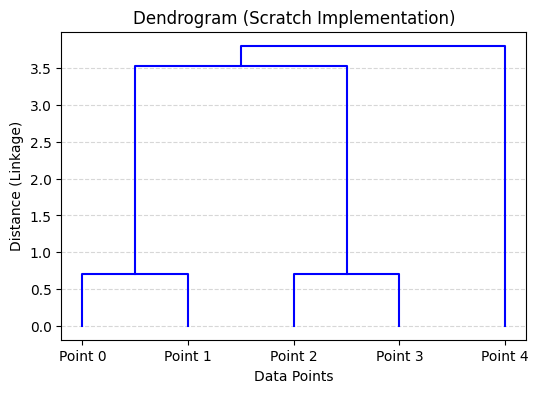

In [18]:
icoord_scratch, dcoord_scratch, leaf_order = compute_dendrogram_coords(Z, n_points)

print("\n--- スクラッチ計算結果 ---")
print("葉の順序 (leaf_order):", leaf_order)

# 5. 描画
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Dendrogram (Scratch Implementation)")

# 各枝を描画
for xs, ys in zip(icoord_scratch, dcoord_scratch):
    ax.plot(xs, ys, 'b-')

# X軸の目盛りとラベルを設定
# X座標は 1, 3, 5, ... となるため、目盛りは 1, 3, 5, ...
leaf_x_coords = [2 * i + 1 for i in range(n_points)]
ax.set_xticks(leaf_x_coords)
ax.set_xticklabels([f"Point {i}" for i in leaf_order])
ax.set_ylabel('Distance (Linkage)')
ax.set_xlabel('Data Points')
ax.grid(axis='y', linestyle='--', alpha=0.5)

## フィルタリングしたデンドログラムの描画

### strahler

In [34]:
_Z, node_id_map = filter_linkage_matrix_by_strahler(Z, S_min=4, N_leaves=len(_get_leaves(clusterer._raw_tree)))
segments = get_dendrogram_segments2(_Z[:, [0, 1, 3, 4]])
fig = plot_dendrogram_plotly(segments).show()

344
[ 70.          71.         174.           0.17586493   2.
   2.        ]

--- ストラー数の分布 ---
ストラー数 2: 25 本の枝
ストラー数 3: 34 本の枝
ストラー数 4: 113 本の枝

--- フィルタリング結果 ---
元のZ行列の行数: 172
ストラー数 >= 4 の行数: 113
root: 344.0
Leaves: 114
Number of leaves: 114
Total Node ID Map Size: 227
current_id: 227


### 適当な値

In [35]:
def compute_stability_python(condensed_tree):

    # 1. 最小クラスタとクラスタ数を定義 (Cythonと同じロジック)
    smallest_cluster = condensed_tree['parent'].min()
    num_clusters = condensed_tree['parent'].max() - smallest_cluster + 1
    
    largest_child = max(condensed_tree['child'].max(), smallest_cluster)

    # 2. lambda_birth の計算 (クラスタの誕生時の最小 lambda)
    # condensed_tree を 'child' でソート
    sorted_child_data = np.sort(condensed_tree[['child', 'lambda_val']], axis=0)
    
    # births_arr は、child ID に対応する lambda_birth を保持する
    births_arr = np.nan * np.ones(largest_child + 1, dtype=np.double)
    
    current_child = -1
    min_lambda = 0

    # NumPyの structured array を Pythonループで処理 (Cythonの loopを模倣)
    for row in range(sorted_child_data.shape[0]):
        child = sorted_child_data[row]['child']
        lambda_ = sorted_child_data[row]['lambda_val']

        if child == current_child:
            min_lambda = min(min_lambda, lambda_)
        elif current_child != -1:
            births_arr[current_child] = min_lambda
            current_child = child
            min_lambda = lambda_
        else:
            # Initialize
            current_child = child
            min_lambda = lambda_

    if current_child != -1:
        births_arr[current_child] = min_lambda
        
    births_arr[smallest_cluster] = 0.0 # ルートクラスタの lambda_birth は 0
    
    # 3. Stability スコアの計算
    
    # NumPyのベクトル演算で高速化可能だが、Cythonを模倣しループで計算
    result_arr = np.zeros(num_clusters, dtype=np.double)
    
    parents = condensed_tree['parent']
    sizes = condensed_tree['child_size']
    lambdas = condensed_tree['lambda_val']

    for i in range(condensed_tree.shape[0]):
        parent = parents[i]
        lambda_ = lambdas[i]
        child_size = sizes[i]
        result_index = parent - smallest_cluster
        
        # Stability(C) = Σ (lambda_death - lambda_birth) * size
        # condensed_treeの各行は、parent が child_size のクラスタを 'lambda_' で吸収/結合するステップを示す
        # この lambda_ は、HDBSCANロジックでは lambda_death と見なされる
        
        lambda_birth = births_arr[parent]
        
        # NOTE: HDBSCANのStability定義は複雑なため、ここはHDBSCANの内部ロジックを正確に模倣する必要があります。
        # オリジナルのCythonコードを再現:
        result_arr[result_index] += (lambda_ - lambda_birth) * child_size
        
    # 4. ID とスコアを辞書に変換
    node_ids = np.arange(smallest_cluster, condensed_tree['parent'].max() + 1)
    result_pre_dict = np.vstack((node_ids, result_arr)).T

    # フィルタリングされていないノードを含むため、dictに変換してIDとスコアを対応させる
    # [ID, Score] のペアの配列を辞書に変換
    return dict(zip(result_pre_dict[:, 0].astype(int), result_pre_dict[:, 1]))

In [ ]:
stability_dict = compute_stability_python(clusterer._raw_tree)

In [ ]:

node_id_map1_reversed = {v: k for k, v in node_id_map.items()}
scores = [stability_dict[node_id_map1_reversed[int(row[2])]] for row in Z] # parent ID -> stability score

def filter_linkage_matrix_by_score(Z, scores, threshold, n_points):
    """
    Z行列とスコアに基づき、フィルタリングされた枝とその子孫をマークし、
    フィルタされたノードを除いた情報でデンドログラム座標計算の準備をする。

    Args:
        Z (np.ndarray): 連結行列 (N-1 x 4)。
        scores (list/np.ndarray): Zの各行に対応するスコア (N-1)。
        threshold (float): スコアのフィルタリング閾値。
        n_points (int): 元のデータ点数。
    """
    n_nodes = 2 * n_points - 1
    
    # ノード情報の初期化
    # 葉ノード (0～n_points-1): 常にフィルタなし、スコアなし
    nodes = [{'is_filtered': False, 'score': None, 'children': []} for _ in range(n_points)]
    
    # 内部ノード (n_points～2*n_points-2): スコアとフィルタ状態を設定
    for i in range(n_points - 1):
        c1, c2, dist, count = Z[i]
        node_idx = n_points + i
        
        # フィルタリング条件: スコアが閾値を下回る
        is_filtered = (scores[i] < threshold)
        
        nodes.append({
            'is_filtered': is_filtered,
            'score': scores[i],
            'left': int(c1),
            'right': int(c2),
            # 簡略化のため、ここではleft/rightを使用
            'Z_row_index': i # Z行列の元のインデックス
        })
        
        # 既に作成された子ノードにも親子関係を逆向きに記録しておくと便利だが、
        # ここでは再帰で順方向 (親→子) に伝播させることに集中する。
    
    return nodes

def propagate_filter_state(nodes, node_idx):
    """
    指定されたノードがフィルタされている場合、その子孫ノードもフィルタ済みにマークする。
    """
    node = nodes[node_idx]
    
    # ノード自体が既にフィルタされていれば、子孫にも伝播させる
    if node['is_filtered'] == True:
        
        # ベースケース: 葉ノード (伝播終了)
        if node_idx < n_points:
            return
            
        # 再帰ステップ: 内部ノード
        # 左右の子ノードが存在する場合、子ノードもフィルタ済みにマークし、再帰呼び出し
        
        # 左の子ノードの処理
        left_idx = node['left']
        if left_idx < len(nodes): # 存在チェック
             # 子ノードをフィルタ済みに上書き
            nodes[left_idx]['is_filtered'] = True 
            propagate_filter_state(nodes, left_idx)
        
        # 右の子ノードの処理
        right_idx = node['right']
        if right_idx < len(nodes): # 存在チェック
             # 子ノードをフィルタ済みに上書き
            nodes[right_idx]['is_filtered'] = True
            propagate_filter_state(nodes, right_idx)

# ルートノードから伝播を開始 (最後のマージ操作がルートノードに対応)
root_node_idx = len(nodes) - 1


def get_filtered_z_and_map(Z, nodes, n_points):
    """
    フィルタされていないマージ操作のみを含む新しい連結行列Z'を作成し、
    デンドログラム描画に必要な情報（IDマッピング）を準備する。
    """
    # フィルタされていないノードに対応するZの行を取得
    unfiltered_Z_rows = []
    
    # 葉ノード（データ点）は常に存在するため、ここでは内部ノード（Zの行）をチェック
    for i in range(n_points - 1):
        node_idx = n_points + i
        if not nodes[node_idx]['is_filtered']:
            unfiltered_Z_rows.append(Z[i])
            
    # フィルタ後の新しいZ'（連結行列）
    if not unfiltered_Z_rows:
        # すべてフィルタされた場合、空の行列を返す
        return np.array([]), None
        
    Z_prime = np.array(unfiltered_Z_rows)
    
    # Z_primeの行数は元のN-1よりも小さくなる

    # フィルタされた枝のデンドログラム描画をどうするかは、設計上の選択になります:
    # 1. フィルタされた枝を「ノイズ」として扱う
    # 2. フィルタされたノードを、その親ノードのY座標で「打ち切り」として描画する
    
    # 💡 重要な点: Z'はもはや連結行列として完全な木構造を表現していない
    # そのため、Z'をそのまま座標計算関数に渡すのではなく、
    # フィルタされたノードの情報を利用して描画ロジックを修正する必要があります。

    return Z_prime
